Based on the MetPy example ["Station Plot with Layout"](http://metpy.readthedocs.org/en/latest/examples/generated/Station_Plot_with_Layout.html)

(Apr 10 16 12:52:00 , Apr 10 16 12:52:00 )
425
85


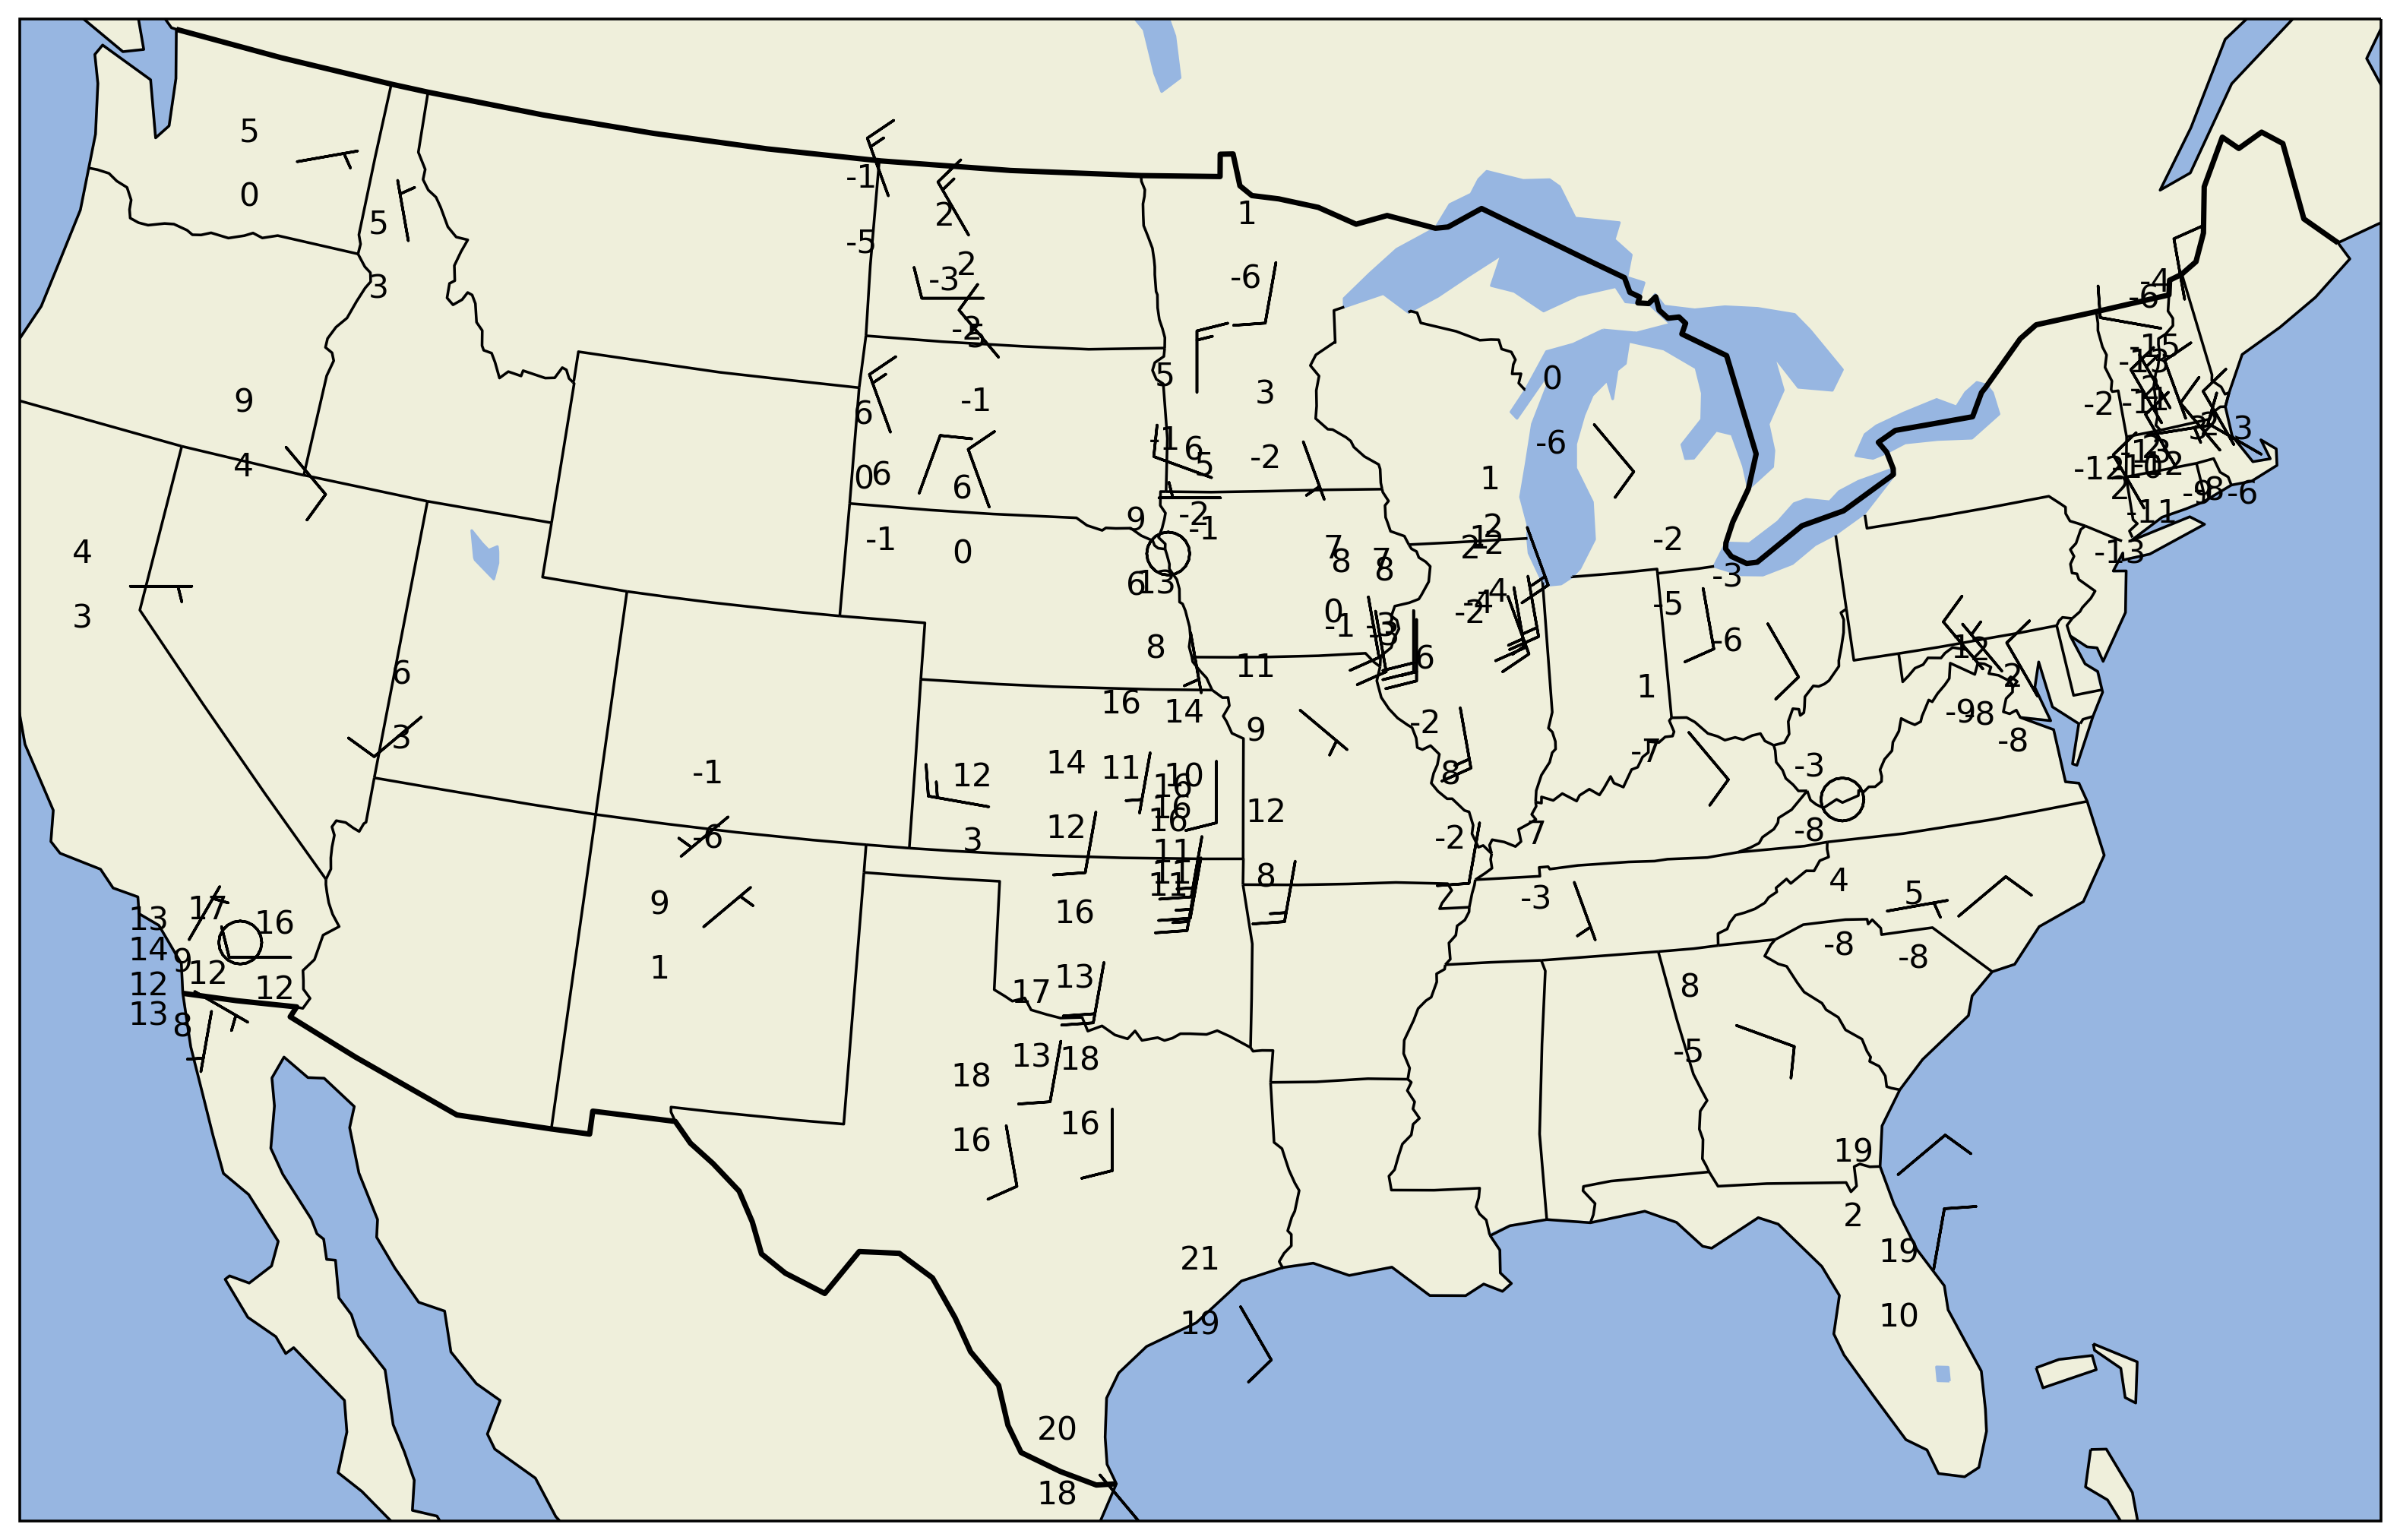

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from awips.dataaccess import DataAccessLayer

from metpy.calc import get_wind_components
from metpy.cbook import get_test_data
from metpy.plots import StationPlot, StationPlotLayout, simple_layout
from metpy.units import units

# Initialize
DataAccessLayer.changeEDEXHost("edex-cloud.unidata.ucar.edu")

data,latitude,longitude,stationName,temperature,dewpoint,seaLevelPress,windDir,windSpeed = [],[],[],[],[],[],[],[],[]
request = DataAccessLayer.newDataRequest()
request.setDatatype("obs")


#
# we need to set one station to query latest time.  this is hack-y and should be fixed
# because when you DON'T set a location name, you tend to get a single observation
# that came in a second ago, so your "latest data for the last time for all stations"
# data array consists of one village in Peru and time-matching is suspect right now.
#
# So here take a known US station (OKC) and hope/assume that a lot of other stations 
# are also reporting (and that this is a 00/20/40 ob). 
#
request.setLocationNames("KOKC")
datatimes = DataAccessLayer.getAvailableTimes(request)

# Get most recent time for location
time = datatimes[0].validPeriod

# "presWeather","skyCover","skyLayerBase"
# are multi-dimensional(??) and returned seperately (not sure why yet)... deal with those later
request.setParameters("presWeather","skyCover", "skyLayerBase","stationName","temperature","dewpoint","windDir","windSpeed",
                      "seaLevelPress","longitude","latitude")
request.setLocationNames()
response = DataAccessLayer.getGeometryData(request,times=time)
print time
PRES_PARAMS = set(["presWeather"])
SKY_PARAMS = set(["skyCover", "skyLayerBase"])
# Build ordered arrays
wx,cvr,bas=[],[],[]
for ob in response:
    #print ob.getParameters()
    if set(ob.getParameters()) & PRES_PARAMS :
        wx.append(ob.getString("presWeather"))
        continue
    if set(ob.getParameters()) & SKY_PARAMS :
        cvr.append(ob.getString("skyCover"))
        bas.append(ob.getNumber("skyLayerBase"))
        continue
    latitude.append(float(ob.getString("latitude")))
    longitude.append(float(ob.getString("longitude")))
    #stationName.append(ob.getString("stationName"))
    temperature.append(float(ob.getString("temperature")))
    dewpoint.append(float(ob.getString("dewpoint")))
    seaLevelPress.append(float(ob.getString("seaLevelPress")))
    windDir.append(float(ob.getString("windDir")))
    windSpeed.append(float(ob.getString("windSpeed")))
    
    
print len(wx)
print len(temperature)


# Convert
data = dict()
data['latitude']  = np.array(latitude)
data['longitude'] = np.array(longitude)
data['air_temperature'] = np.array(temperature)* units.degC
data['dew_point_temperature'] = np.array(dewpoint)* units.degC
#data['air_pressure_at_sea_level'] = np.array(seaLevelPress)* units('mbar')
u, v = get_wind_components(np.array(windSpeed) * units('knots'),
                           np.array(windDir) * units.degree)
data['eastward_wind'], data['northward_wind'] = u, v

# Convert the fraction value into a code of 0-8, which can be used to pull out
# the appropriate symbol
#data['cloud_coverage'] = (8 * data_arr['cloud_fraction']).astype(int)

# Map weather strings to WMO codes, which we can use to convert to symbols
# Only use the first symbol if there are multiple
#wx_text = make_string_list(data_arr['weather'])
#wx_codes = {'':0, 'HZ':5, 'BR':10, '-DZ':51, 'DZ':53, '+DZ':55,
#            '-RA':61, 'RA':63, '+RA':65, '-SN':71, 'SN':73, '+SN':75}
#data['present_weather'] = [wx_codes[s.split()[0] if ' ' in s else s] for s in wx]

# Set up the map projection
import cartopy.crs as ccrs
import cartopy.feature as feat
from matplotlib import rcParams
rcParams['savefig.dpi'] = 255
proj = ccrs.LambertConformal(central_longitude=-95, central_latitude=35,
                             standard_parallels=[35])
state_boundaries = feat.NaturalEarthFeature(category='cultural',
                                            name='admin_1_states_provinces_lines',
                                            scale='110m', facecolor='none')
# Create the figure
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 1, 1, projection=proj)

# Add map elements 
ax.add_feature(feat.LAND, zorder=-1)
ax.add_feature(feat.OCEAN, zorder=-1)
ax.add_feature(feat.LAKES, zorder=-1)
ax.coastlines(resolution='110m', zorder=2, color='black')
ax.add_feature(state_boundaries)
ax.add_feature(feat.BORDERS, linewidth='2', edgecolor='black')
ax.set_extent((-118, -73, 23, 50))

# Start the station plot by specifying the axes to draw on, as well as the
# lon/lat of the stations (with transform). We also the fontsize to 12 pt.
stationplot = StationPlot(ax, data['longitude'], data['latitude'],
                          transform=ccrs.PlateCarree(), fontsize=12)

# The layout knows where everything should go, and things are standardized using
# the names of variables. So the layout pulls arrays out of `data` and plots them
# using `stationplot`.
simple_layout.plot(stationplot, data)